<h2><b>Sentiment Analysis of IMDb Movie Reviews</b></h2>







<h2><b>A - Introduction</b></h2>


Sentiment Analysis refers to a technique that utilizes Natural Language Processing techniques in order to determine whether a statement is positive or negative. In this project, we
will utilize Sentiment Analysis on IMDb movie reviews in order to judge whether a movie has
a generally positive or negative favor among public perception. Employing different classification models (SVM, Random Forest, XG-Boost, LSTM, and BERT), we hope to compare their
benchmarks to one another to determine which models are best for Sentiment Analysis in order to see which model would be best to use to determine whether the general sentiment about a
movie is positive or negative.

<h2><b>B - Setup</b></h2>


<h2><b>1. Load Essential Libraries</b></h2>


In [ ]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import nltk
from typing import List
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

<h2><b>2. Load Dataset</b></h2>

The dataset used in this project is the “IMDb Movie Ratings Sentiment Analysis” dataset available
on Kaggle1. It consists of 40,000 movie reviews, each labeled with a sentiment value: 1 for positive
and 0 for negative. The dataset is balanced, with approximately 50% of the reviews belonging to
each sentiment class

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving IMDB dataset.csv to IMDB dataset.csv


In [ ]:
df = pd.read_csv("IMDB dataset.csv")

<h2><b>2. Data Preparation</b></h2>

This section handles the input text by removing HTML tags, URLs, emails, digits, punctuation, extra spaces, and converting it to lowercase.

In [ ]:
lemmatizer = WordNetLemmatizer()
def clean_text(text: str) -> str:
    """
    - Remove HTML tags
    - Remove URLs and emails
    - Remove digits
    - Remove punctuation/special chars
    - Collapse multiple spaces
    - Lowercase
    """
    # Strip HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    # Lowercase
    text = text.lower()
    # Remove URLs and emails
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)
    # Remove digits
    text = re.sub(r"\d+", "", text)
    # Remove punctuation (keep letters and whitespace)
    text = re.sub(r"[^\w\s]", " ", text)
    # Collapse whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
df["clean_text"] = df["text"].apply(clean_text)


In [ ]:
# quick check
df[["text", "clean_text"]].head()

,text,clean_text
0,I grew up (b. 1965) watching and loving the Th...,i grew up b watching and loving the thunderbir...
1,"When I put this movie in my DVD player, and sa...",when i put this movie in my dvd player and sat...
2,Why do people who do not know what a particula...,why do people who do not know what a particula...
3,Even though I have great interest in Biblical ...,even though i have great interest in biblical ...
4,Im a die hard Dads Army fan and nothing will e...,im a die hard dads army fan and nothing will e...


In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


# build your stop‑word set
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def tokenize_and_lemmatize(text: str):
    tokens = word_tokenize(text)
    lemmas = [
        lemmatizer.lemmatize(t)
        for t in tokens
        if t.isalpha() and t not in stop_words
    ]
    return lemmas

In [ ]:
df["tokens"] = df["clean_text"].apply(tokenize_and_lemmatize)

In [ ]:
# inspect
df[['clean_text','tokens']].head()

,clean_text,tokens
0,i grew up b watching and loving the thunderbir...,"[grew, b, watching, loving, thunderbird, mate,..."
1,when i put this movie in my dvd player and sat...,"[put, movie, dvd, player, sat, coke, chip, exp..."
2,why do people who do not know what a particula...,"[people, know, particular, time, past, like, f..."
3,even though i have great interest in biblical ...,"[even, though, great, interest, biblical, movi..."
4,im a die hard dads army fan and nothing will e...,"[im, die, hard, dad, army, fan, nothing, ever,..."


In [ ]:
from sklearn.model_selection import train_test_split

# join the tokens
df['tokens_joined'] = df['tokens'].apply(lambda toks: " ".join(toks))

X = df['tokens_joined']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

<h2><b>2.1 TF-IDF (Unigrams Only)</b></h2>

For traditional machine learning models (SVM, Random Forest, XG-
Boost), we apply TfidfVectorizer using only unigrams. This sparse feature representation captures the importance of individual terms by weighting them inversely by document frequency. We cap the vocabulary at 20,000 terms to limit dimensionality and overfitting.

In [ ]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(
    max_features=20_000,    # cap your vocab size
    ngram_range=(1,1),      # only unigrams
    #  ngram_range=(1,2)
)

# fit on train, transform both splits
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

print("TF‑IDF →",
      X_train_tfidf.shape, "train samples × features")


TF‑IDF → (32000, 20000) train samples × features


<h2><b> 2.2 CountVectorizer with N-Gram</b></h2>

We also use CountVectorizer with an n-gram range of 1
to 3 to extract frequently occurring word sequences (unigrams, bigrams, and trigrams). This approach captures simple phrase patterns without any weighting, and is particularly useful for traditional models that benefit from phrase-level features

In [ ]:
# N-Gram vectorization
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer
count_vect = CountVectorizer(
    max_features=20_000,
    ngram_range=(1,3),
)

X_train_count = count_vect.fit_transform(X_train)
X_test_count  = count_vect.transform(X_test)

print("n‑gram Count →",
      X_train_count.shape, "train samples × features")

n‑gram Count → (32000, 20000) train samples × features


<h2><b> 2.3 GloVe Vectorization</b></h2>

We use the pre-trained 25-dimensional glove-twitter-25 embed-
dings from Gensim to convert each review into a dense vector by averaging the word vectors of all valid (non-stopword) tokens. This embedding-based representation captures semantic similarities between words and provides dense input for traditional classifiers.

In [ ]:
# Manual download & loading of GloVe
import os, zipfile, requests, io, re
import numpy as np
from sklearn.model_selection import train_test_split

# Download and unzip GloVe Twitter 25d
url = "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extract("glove.twitter.27B.25d.txt", path="glove")

# Read glove file to dictionary
glove_path = "glove/glove.twitter.27B.25d.txt"
glove_dict = {}
with open(glove_path, "r", encoding="utf8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vec  = np.array(parts[1:], dtype=np.float32)
        glove_dict[word] = vec

# Create doc2vec function
import nltk
nltk.download("stopwords")
stop_words = set(nltk.corpus.stopwords.words("english"))

def doc2vec_manual(text: str) -> np.ndarray:
    tokens = re.findall(r"\b\w+\b", text.lower())
    vecs = [glove_dict[t] for t in tokens if t not in stop_words and t in glove_dict]
    return np.mean(vecs, axis=0) if vecs else np.zeros(25, dtype=np.float32)

# Vectorized complete set and divided 80/20
X_glove = np.vstack(df["tokens_joined"].apply(doc2vec_manual).values)
y       = df["label"].values
X_train_glove, X_test_glove, y_train, y_test = train_test_split(
    X_glove, y, stratify=y, test_size=0.2, random_state=42
)

print("GloVe →", X_train_glove.shape, "train samples × 25-dim features")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


GloVe → (32000, 25) train samples × 25-dim features


<h2><b>3. Classification Models</b></h2>

We implemented five classification models in our project. Each model was trained and tested on the same splits
. The models include: Support Vector Machine (SVM), Random
Forest, XGBoost, Long Short-Term Memory (LSTM), and BERT.

<h2><b>3.1 Support Vector Machine (SVM)</b></h2>

SVM is widely regarded as one of the best methods of conducting supervised learning. The main
idea of SVM is to map the data to a 2D plane, and then find an optimal hyperplane to separate the
data into classes, in this case, ”Positive” or ”Negative” sentiment. We implemented SVM using the
LinearSVC class from scikit-learn. The input feature was generated using TfidfVectorizer,
with an n-gram range of (1,6), a maximum vocabulary size of 20,000, and English stopwords
removed. The model was trained on this sparse TF-IDF matrix, and hyperparameters were left at
default

In [ ]:
# Train and eval SVM on TF-IDF
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

svm_tfidf = LinearSVC(max_iter=5000, random_state=42)

svm_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = svm_tfidf.predict(X_test_tfidf)
print("TF‑IDF SVM Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))


TF‑IDF SVM Accuracy: 0.888
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4004
           1       0.89      0.89      0.89      3996

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000



In [ ]:
# Train and eval SVM on n-gram
svm_count = LinearSVC(max_iter=5000, random_state=42)

svm_count.fit(X_train_count, y_train)
y_pred_count = svm_count.predict(X_test_count)

print("n‑gram Count SVM Accuracy:", accuracy_score(y_test, y_pred_count))
print(classification_report(y_test, y_pred_count))


n‑gram Count SVM Accuracy: 0.863
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4004
           1       0.86      0.86      0.86      3996

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000



In [ ]:
# x GloVe + SVM ——
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

svm_glove = LinearSVC(max_iter=5000, random_state=42)
svm_glove.fit(X_train_glove, y_train)

y_pred_svm_glove = svm_glove.predict(X_test_glove)
print("GloVe + SVM Accuracy:", accuracy_score(y_test, y_pred_svm_glove))
print(classification_report(y_test, y_pred_svm_glove, digits=3))

GloVe + SVM Accuracy: 0.756
              precision    recall  f1-score   support

           0      0.754     0.761     0.757      4004
           1      0.758     0.751     0.755      3996

    accuracy                          0.756      8000
   macro avg      0.756     0.756     0.756      8000
weighted avg      0.756     0.756     0.756      8000



<h2><b>3.2 Random Forest Classifier</b></h2>

Random Forest is a classification method that utilizes a multitude of decision trees in order to avoid
overfitting and improve accuracy. By taking the average, or using the most-common classification
of the trees in the ”forest” of decision trees, Random Forest seeks to predict the most likely classifi-
cation of the movie review. We implemented it using using scikit-learn again, with the number
of trees set to 100. Similar to SVM, the model was trained on the same TF-IDF input features.

In [ ]:
# Train and eval Random-Forest on TF-IDF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_tfidf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_tfidf.fit(X_train_tfidf, y_train)

y_pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf)
print("TF‑IDF RF Accuracy:", accuracy_score(y_test, y_pred_rf_tfidf))
print(classification_report(y_test, y_pred_rf_tfidf))


TF‑IDF RF Accuracy: 0.85325
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      4004
           1       0.86      0.85      0.85      3996

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



In [ ]:
# Train and eval Random-Forest on N-Gram
rf_count = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_count.fit(X_train_count, y_train)

y_pred_rf_count = rf_count.predict(X_test_count)
print("n‑gram Count RF Accuracy:", accuracy_score(y_test, y_pred_rf_count))
print(classification_report(y_test, y_pred_rf_count))


n‑gram Count RF Accuracy: 0.85025
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4004
           1       0.85      0.85      0.85      3996

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



In [ ]:
# x GloVe + Random Forest ——
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_glove = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_glove.fit(X_train_glove, y_train)

y_pred_rf_glove = rf_glove.predict(X_test_glove)
print("GloVe + RF Accuracy:", accuracy_score(y_test, y_pred_rf_glove))
print(classification_report(y_test, y_pred_rf_glove, digits=3))


GloVe + RF Accuracy: 0.749625
              precision    recall  f1-score   support

           0      0.753     0.744     0.748      4004
           1      0.746     0.756     0.751      3996

    accuracy                          0.750      8000
   macro avg      0.750     0.750     0.750      8000
weighted avg      0.750     0.750     0.750      8000



<h2><b>3.3 XGBoost Classifier</b></h2>

XGBoost stands for Extreme Gradient Boosting. THe main idea of this classification method is to
start by creating a decision tree with the training data. The error is then computed, and a tree
is then created to predict those errors. This process of computing the error and repeating is done
repeatedly, adding on the trees to the previous ones, until a final prediction is formed from the sum
of all of the trees. We used the XGBClassifier from the xgboost library to implement this, and
it was trained on both TF-IDF and Count-based N-Gram representations

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train and eval XG-Boost on TF-IDF
xgb_tfidf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_tfidf.fit(X_train_tfidf, y_train)

y_pred_xgb_tfidf = xgb_tfidf.predict(X_test_tfidf)
print("TF‑IDF XGB Accuracy:", accuracy_score(y_test, y_pred_xgb_tfidf))
print(classification_report(y_test, y_pred_xgb_tfidf))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:00:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


TF‑IDF XGB Accuracy: 0.850875
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4004
           1       0.84      0.87      0.85      3996

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



In [ ]:
# Train and eval XG-Boost on N-Gram
xgb_count = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_count.fit(X_train_count, y_train)

y_pred_xgb_count = xgb_count.predict(X_test_count)
print("n‑gram Count XGB Accuracy:", accuracy_score(y_test, y_pred_xgb_count))
print(classification_report(y_test, y_pred_xgb_count))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:03:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


n‑gram Count XGB Accuracy: 0.85275
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4004
           1       0.84      0.87      0.86      3996

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



In [ ]:
# x GloVe + XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

xgb_glove = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
xgb_glove.fit(X_train_glove, y_train)

y_pred_xgb_glove = xgb_glove.predict(X_test_glove)
print("GloVe + XGB Accuracy:", accuracy_score(y_test, y_pred_xgb_glove))
print(classification_report(y_test, y_pred_xgb_glove, digits=3))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:03:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GloVe + XGB Accuracy: 0.75275
              precision    recall  f1-score   support

           0      0.753     0.752     0.753      4004
           1      0.752     0.753     0.753      3996

    accuracy                          0.753      8000
   macro avg      0.753     0.753     0.753      8000
weighted avg      0.753     0.753     0.753      8000



<h2><b>3.4 LSTM</b></h2>

We implemented a custom LSTM network using PyTorch. Reviews were first tokenized using nltk.word tokenize, and then numericalized using a custom vocabulary built from the training corpus. Each review was padded to a fixed length of 256 tokens. Word embeddings were learned from scratch. We used two hidden layers, with the hidden layer’s dimension being 128. A dropout of 0.3 was applied after pooling to reduce overfitting. Our LSTM network was trained over 10
epochs.

In [ ]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, vocabulary, max_length=256):
        """
        Create the IMDBDataset class.
        """
        self.texts = texts
        self.vocabulary = vocabulary
        self.max_length = max_length
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(labels) # Encode labels into integers
    def __len__(self):
        """
        Return the total number of samples.
        """
        return len(self.texts)
    def __getitem__(self, idx):
        """
        Return a single sample.
        """
        tokens = word_tokenize(self.texts[idx])
        ids = [self.vocabulary.get(t, self.vocabulary.get("<UNK>", 0)) for t in tokens][:self.max_length] # Convert tokens to IDs
        padding = [0] * (self.max_length - len(ids)) # Padding
        ids = ids + padding
        label = self.encoded_labels[idx]
        return torch.LongTensor(ids), torch.LongTensor([label])

In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preprocess text and labels
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences  = tokenizer.texts_to_sequences(X_test)
max_length = 256
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_pad  = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')
label_encoder = LabelEncoder()
y_train_encoder = label_encoder.fit_transform(y_train)
print("Text:", X_train.iloc[0])
print("Original tokens:", tokenizer.texts_to_sequences([X_train.iloc[0]])[0])
print("Padded input:\n", X_train_pad[0])
print("Label:", y_train_encoder[0])

Text: accidentally stumbled across script textual form would read maybe laugh would however laugh point film director would seem want laugh although still altogether sure care woody allen writer write dialogue least knowingly write dialogue draw performance actor capable drawing laughter even ticklish clown example paraphrase art historian looking get job art gallery ok state fact honestly know art historian would say would answer really art gallery would thought entire script littered kind tawdry quasi intellectualism would expected respected character writer admit knowledge allen work judging one want start learning character loathsome without exception attempt illustrate suffer human condition really really poor character writing judge
Original tokens: [2265, 4521, 489, 121, 1, 594, 11, 220, 174, 200, 11, 102, 200, 82, 3, 57, 11, 201, 59, 200, 166, 53, 3326, 150, 290, 2593, 1531, 267, 752, 286, 124, 13937, 752, 286, 1525, 67, 35, 1922, 2949, 1871, 10, 1, 3130, 309, 9895, 302, 5506, 

In [ ]:
dataset = IMDBDataset(
    texts=X_train.tolist(),
    labels=y_train.tolist(),
    vocabulary=tokenizer.word_index,
    max_length=256
)
tokens_tensor, label_tensor = dataset[0]
print("Total number of samples:", len(dataset))
print("First Sample:")
print(tokens_tensor)

Total number of samples: 32000
First Sample:
tensor([ 2265,  4521,   489,   121, 26152,   594,    11,   220,   174,   200,
           11,   102,   200,    82,     3,    57,    11,   201,    59,   200,
          166,    53,  3326,   150,   290,  2593,  1531,   267,   752,   286,
          124, 13937,   752,   286,  1525,    67,    35,  1922,  2949,  1871,
           10, 46241,  3130,   309,  9895,   302,  5506,   162,    12,   175,
          302,  6404,   452,   581,    87,  1024,    32,   302,  5506,    11,
           44,    11,   933,    15,   302,  6404,    11,    88,   328,   121,
        13938,   129, 14900,  7218, 26153,    11,   705,  4356,     8,   267,
          806,  1657,  1531,    54,  3662,     4,    59,   137,  2502,     8,
        13108,   112,  1094,   287,  8616,  2615,   238,  1903,    15,    15,
          230,     8,   373,  1306,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     

In [ ]:
import torch.nn as nn
# LSTM model
class SentimentLSTM(nn.Module):
    def __init__(
        self,
        vocab_size, # Size of vocabulary
        emb_dim=100, # Embedding dimension
        hidden_dim=128, # LSTM hidden dimension
        n_layers=2, # LSTM layers
        n_classes=2, # Number of output classes(0 or 1)
        dropout=0.3 # Dropout rate
    ):
        super().__init__()
        # Embedding and dropout
        self.embed  = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.drop_e = nn.Dropout(dropout)
        # Process sequence
        self.lstm = nn.LSTM(
            emb_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.drop_h = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 4, n_classes)

    def forward(self, x):
        # Convert words to vectors
        E = self.drop_e(self.embed(x))
        H, _ = self.lstm(E)
        # Extract features
        avg_pool = H.mean(dim=1)
        max_pool, _ = H.max(dim=1)
        cat = torch.cat([avg_pool, max_pool], dim=1)
        cat = self.drop_h(cat)
        return self.fc(cat)


In [ ]:
from collections import Counter
from torch.utils.data import DataLoader
counter = Counter()
for txt in X_train:
    counter.update(word_tokenize(txt))
most_common = counter.most_common(20000)
vocab = {w:i+1 for i,(w,_) in enumerate(most_common)}
vocab["<UNK>"] = len(vocab)+1

train_ds = IMDBDataset(X_train.tolist(), y_train.tolist(), vocab)
test_ds  = IMDBDataset(X_test.tolist(),  y_test.tolist(),  vocab)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64)

In [ ]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentLSTM(len(vocab)+1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
test_accuracys = []
test_precisions = []
test_recalls = []
test_f1s = []

for epoch in range(1, 11):
    model.train()
    total_loss = 0
    train_loader_tq = tqdm(
        train_loader, desc=f"Epoch {epoch} [Train]", unit="batch", leave=False
    )
    for x_batch, y_batch in train_loader_tq:
        optimizer.zero_grad()
        x_batch, y_batch = x_batch.to(device), y_batch.squeeze().to(device)
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    predictions_all = []
    labels_all = []
    with torch.no_grad():
        for xb, yb in tqdm(test_loader, desc=f"Epoch {epoch} [Test] ", leave=False):
            xb = xb.to(device)
            logits = model(xb)
            predictions = logits.argmax(dim=1).cpu()
            label_values = yb.squeeze().cpu()
            predictions_all.extend(predictions.numpy())
            labels_all.extend(label_values.numpy())

    # compute metrics
    accuracy = accuracy_score(labels_all, predictions_all)
    precision = precision_score(labels_all, predictions_all, average='binary', zero_division=0)
    recall = recall_score(labels_all, predictions_all, average='binary', zero_division=0)
    f1 = f1_score(labels_all, predictions_all, average='binary', zero_division=0)

    test_accuracys.append(accuracy)
    test_precisions.append(precision)
    test_recalls.append(recall)
    test_f1s.append(f1)

    print(f"Epoch {epoch:2d} loss: {avg_loss:.4f} accuracy: {accuracy:.4f}\n"
           f"precision: {precision:.4f} recall: {recall:.4f} f1: {f1:.4f}")

Epoch  1 loss: 0.4875 accuracy: 0.8509
precision: 0.8388 recall: 0.8684 f1: 0.8533


Epoch  2 loss: 0.3284 accuracy: 0.8738
precision: 0.8734 recall: 0.8739 f1: 0.8737


Epoch  3 loss: 0.2701 accuracy: 0.8730
precision: 0.9084 recall: 0.8293 f1: 0.8671


Epoch  4 loss: 0.2300 accuracy: 0.8904
precision: 0.8793 recall: 0.9047 f1: 0.8918


Epoch  5 loss: 0.2021 accuracy: 0.8898
precision: 0.8966 recall: 0.8809 f1: 0.8887


Epoch  6 loss: 0.1769 accuracy: 0.8920
precision: 0.8931 recall: 0.8904 f1: 0.8917


Epoch  7 loss: 0.1539 accuracy: 0.8906
precision: 0.8776 recall: 0.9077 f1: 0.8924


Epoch  8 loss: 0.1344 accuracy: 0.8908
precision: 0.8778 recall: 0.9077 f1: 0.8925


Epoch  9 loss: 0.1185 accuracy: 0.8932
precision: 0.8854 recall: 0.9032 f1: 0.8942


Epoch 10 loss: 0.0986 accuracy: 0.8876
precision: 0.8663 recall: 0.9164 f1: 0.8907


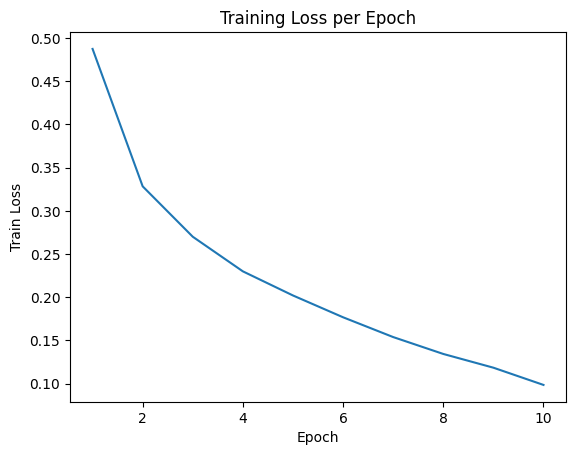

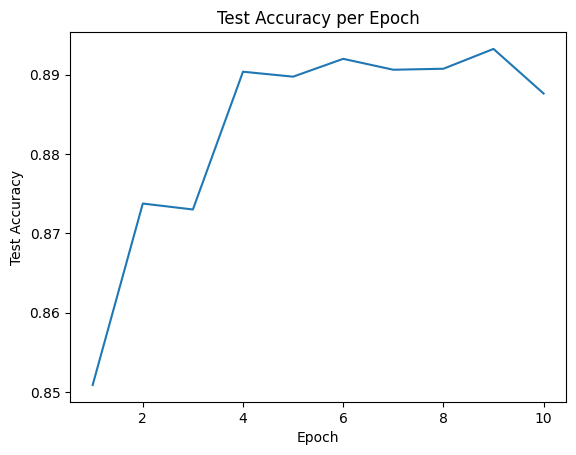

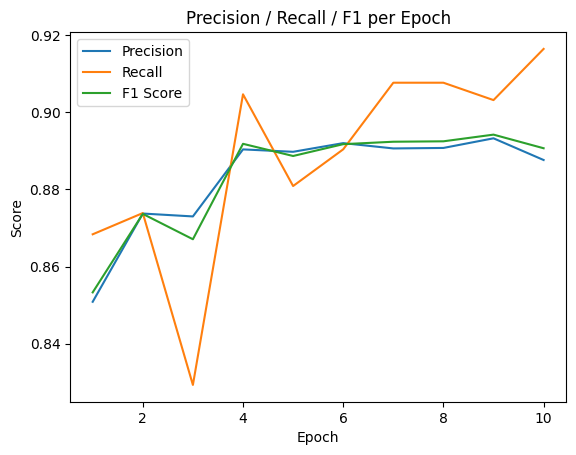

In [ ]:
# a) train accuracy
plt.figure()
plt.plot(range(1, 11), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss per Epoch")
plt.show()

# b) test accuracy
plt.figure()
plt.plot(range(1, 11), test_accuracys)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy per Epoch")
plt.show()

# c) precision, recall & F1 together
plt.figure()
plt.plot(range(1, 11), test_accuracys, label="Precision")
plt.plot(range(1, 11), test_recalls,  label="Recall")
plt.plot(range(1, 11), test_f1s,   label="F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 per Epoch")
plt.legend()
plt.show()


<h2><b>3.5 BERT</b></h2>

BERT stands for Bidirectional Encoder Representations from Transformers. It is a deep learning model developed by Google AI that is used for language understanding using a transformer architecture. Essentially, BERT is multiple Transformer encoders stacked on top of one another, with each layer containing multi-headed self attention and feed-forward networks.

In [ ]:
from transformers import BertTokenizer
# Dataset for BERT
class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        """
        Create the BERTDataset class.
        """
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(labels)  # Encode labels into integers

    def __len__(self):
        """
        Return the total number of samples.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Return a single sample for BERT:
        """
        # Convert the text into token IDs and attention mask
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        # Remove the batch dimension
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        label = torch.LongTensor([self.encoded_labels[idx]])
        # Return a tuple of inputs and label
        return (input_ids, attention_mask), label

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', quiet=True)
bert_dataset = BERTDataset(X_train.tolist(), y_train.tolist(), tokenizer)
first_sample = 0
(input_ids, attention_mask), label = bert_dataset[first_sample]
print("Text:", X_train.iloc[first_sample])
print("Padded input:\n", input_ids.numpy())
print("Attention mask:\n", attention_mask.numpy())
print("Label:", label.item())

Text: accidentally stumbled across script textual form would read maybe laugh would however laugh point film director would seem want laugh although still altogether sure care woody allen writer write dialogue least knowingly write dialogue draw performance actor capable drawing laughter even ticklish clown example paraphrase art historian looking get job art gallery ok state fact honestly know art historian would say would answer really art gallery would thought entire script littered kind tawdry quasi intellectualism would expected respected character writer admit knowledge allen work judging one want start learning character loathsome without exception attempt illustrate suffer human condition really really poor character writing judge
Padded input:
 [  101  9554  9845  2408  5896 25304  2433  2052  3191  2672  4756  2052
  2174  4756  2391  2143  2472  2052  4025  2215  4756  2348  2145 10462
  2469  2729 13703  5297  3213  4339  7982  2560  4209  2135  4339  7982
  4009  2836  336

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

class BERTSentiment(nn.Module):
    def __init__(self, model_name='bert-base-uncased', n_classes=2, hidden_dim=256, dropout_rate=0.3):
        """
        BERT sentiment classifier.
        """
        super().__init__()
        # Load BERT
        self.bert = BertModel.from_pretrained(model_name, output_hidden_states=True, return_dict=True)
        bert_dim = self.bert.config.hidden_size
        # Layer to reduce dimensions
        self.fc1 = nn.Linear(bert_dim * 2, hidden_dim)
        # Activation function
        self.act = nn.GELU()
        # Add dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, n_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Get last layer output
        last_hidden = out.hidden_states[-1]
        cls_hidden = last_hidden[:, 0]

        mask = attention_mask.unsqueeze(-1)
        # Calculate average of words
        avg_hidden = (last_hidden * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
        # Combine cls_hidden and average features
        x = torch.cat([cls_hidden, avg_hidden], dim=1)
        h = self.fc1(x)
        h = self.act(h)
        h = self.dropout(h)
        return self.fc2(h)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_ds = BERTDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_ds = BERTDataset(X_test.tolist(), y_test.tolist(), tokenizer)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTSentiment().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

train_losses = []
test_accuracys = []
test_precisions = []
test_recalls = []
test_f1s = []

# Training
for epoch in range(1, 11):
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", unit="batch", leave=False)
    total_loss = 0
    for (input_ids, attention_mask), labels in train_bar:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.squeeze().to(device)
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        train_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    # Calculate the loss
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} train loss: {avg_loss:.4f}")
    train_losses.append(avg_loss)

    model.eval()
    predictions_all = []
    labels_all = []
    test_bar = tqdm(test_loader, desc=f"Epoch {epoch} [Test] ", leave=False)
    with torch.no_grad():
        for (input_ids, attention_mask), labels in test_bar:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.squeeze().to(device)
            logits = model(input_ids, attention_mask)
            predictions = logits.argmax(dim=1).cpu().numpy()
            label_values = labels.cpu().numpy()

            predictions_all.extend(predictions)
            labels_all.extend(label_values)

    # compute metrics
    accuracy = accuracy_score(labels_all, predictions_all)
    precision = precision_score(labels_all, predictions_all, average='binary', zero_division=0)
    recall = recall_score(labels_all, predictions_all, average='binary', zero_division=0)
    f1 = f1_score(labels_all, predictions_all, average='binary', zero_division=0)
    test_accuracys.append(accuracy)
    test_precisions.append(precision)
    test_recalls.append(recall)
    test_f1s.append(f1)
    print(f"Epoch {epoch:2d}:loss: {avg_loss:.4f} accuracy: {accuracy:.4f}\n"
          f"precision: {precision:.4f} recall: {recall:.4f} f1: {f1:.4f}")


Epoch 1 train loss: 0.3118


Epoch  1:loss: 0.3118 accuracy: 0.8976
precision: 0.8943 recall: 0.9017 f1: 0.8979


Epoch 2 train loss: 0.2018


Epoch  2:loss: 0.2018 accuracy: 0.9030
precision: 0.9156 recall: 0.8876 f1: 0.9014


Epoch 3 train loss: 0.1377


Epoch  3:loss: 0.1377 accuracy: 0.9015
precision: 0.9280 recall: 0.8704 f1: 0.8982


Epoch 4 train loss: 0.0877


Epoch  4:loss: 0.0877 accuracy: 0.9012
precision: 0.9159 recall: 0.8834 f1: 0.8994


Epoch 5 train loss: 0.0628


Epoch  5:loss: 0.0628 accuracy: 0.8986
precision: 0.9168 recall: 0.8766 f1: 0.8963


Epoch 6 train loss: 0.0507


Epoch  6:loss: 0.0507 accuracy: 0.9052
precision: 0.9033 recall: 0.9074 f1: 0.9054


Epoch 7 train loss: 0.0418


Epoch  7:loss: 0.0418 accuracy: 0.9031
precision: 0.9003 recall: 0.9064 f1: 0.9034


Epoch 8 train loss: 0.0370


Epoch  8:loss: 0.0370 accuracy: 0.8990
precision: 0.8774 recall: 0.9274 f1: 0.9017


Epoch 9 train loss: 0.0359


Epoch  9:loss: 0.0359 accuracy: 0.9071
precision: 0.9129 recall: 0.8999 f1: 0.9064


Epoch 10 train loss: 0.0295


Epoch 10:loss: 0.0295 accuracy: 0.9024
precision: 0.9069 recall: 0.8966 f1: 0.9017


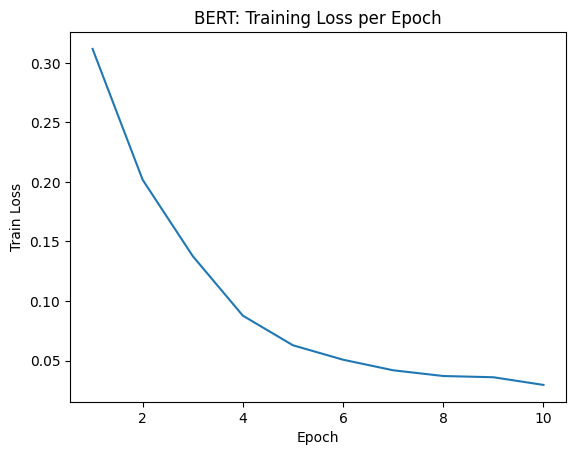

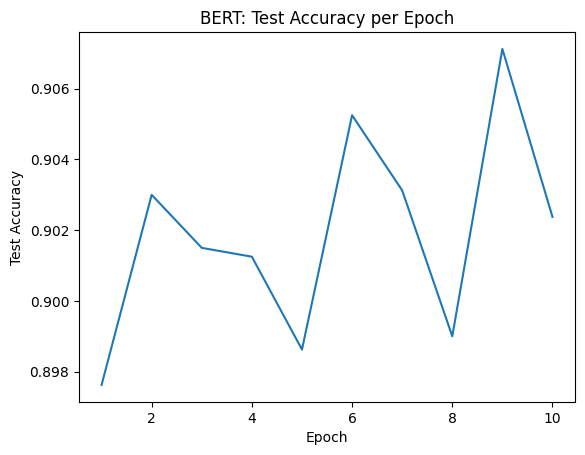

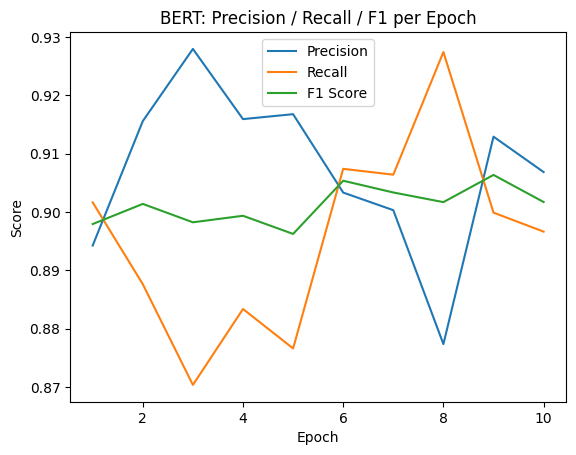

In [ ]:
epochs = list(range(1, 11))

# a) Train loss
plt.figure()
plt.plot(epochs, train_losses)
plt.xlabel("Epoch"); plt.ylabel("Train Loss")
plt.title("BERT: Training Loss per Epoch")
plt.show()

# b) Test accuracy
plt.figure()
plt.plot(epochs, test_accuracys)
plt.xlabel("Epoch"); plt.ylabel("Test Accuracy")
plt.title("BERT: Test Accuracy per Epoch")
plt.show()

# c) Precision, Recall & F1
plt.figure()
plt.plot(epochs, test_precisions, label="Precision")
plt.plot(epochs, test_recalls,  label="Recall")
plt.plot(epochs, test_f1s,   label="F1 Score")
plt.xlabel("Epoch"); plt.ylabel("Score")
plt.title("BERT: Precision / Recall / F1 per Epoch")
plt.legend()
plt.show()